In [1]:
#First install GDAL then GEOPANDAS in that order 

#%conda install gdal

#%pip install geopandas

{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmpcvwbti3j/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=1/part-00119-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2689-1.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmpcvwbti3j/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=2/part-00060-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2630-2.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmpcvwbti3j/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=3/part-00196-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2766-1.c000.snappy.parquet
Columns in the dataset with total and null records:
+----------------------+-----------

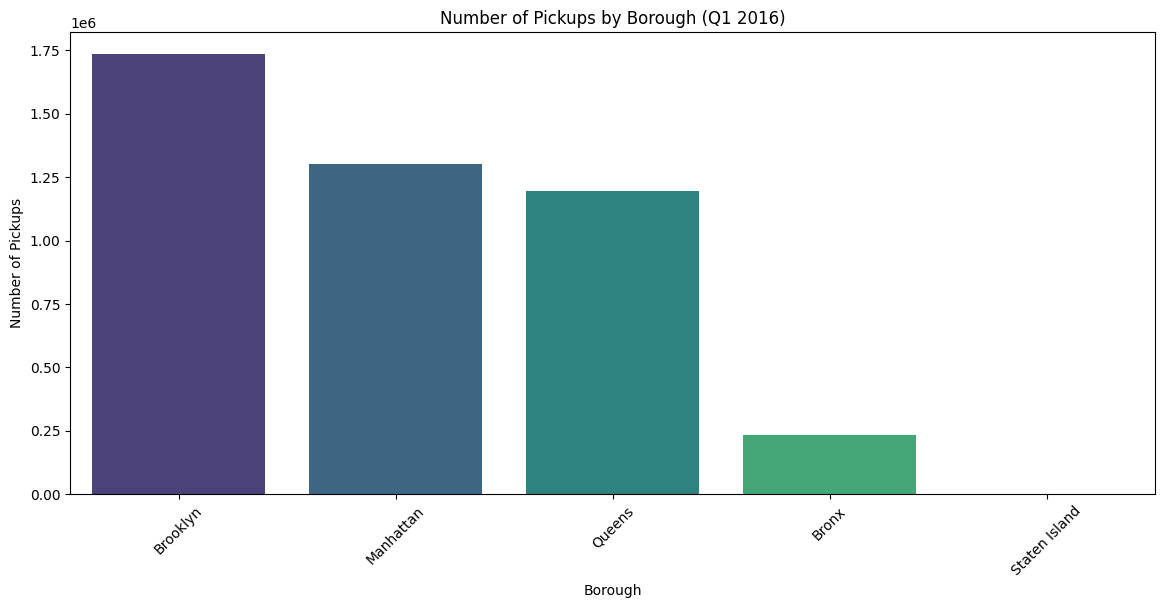

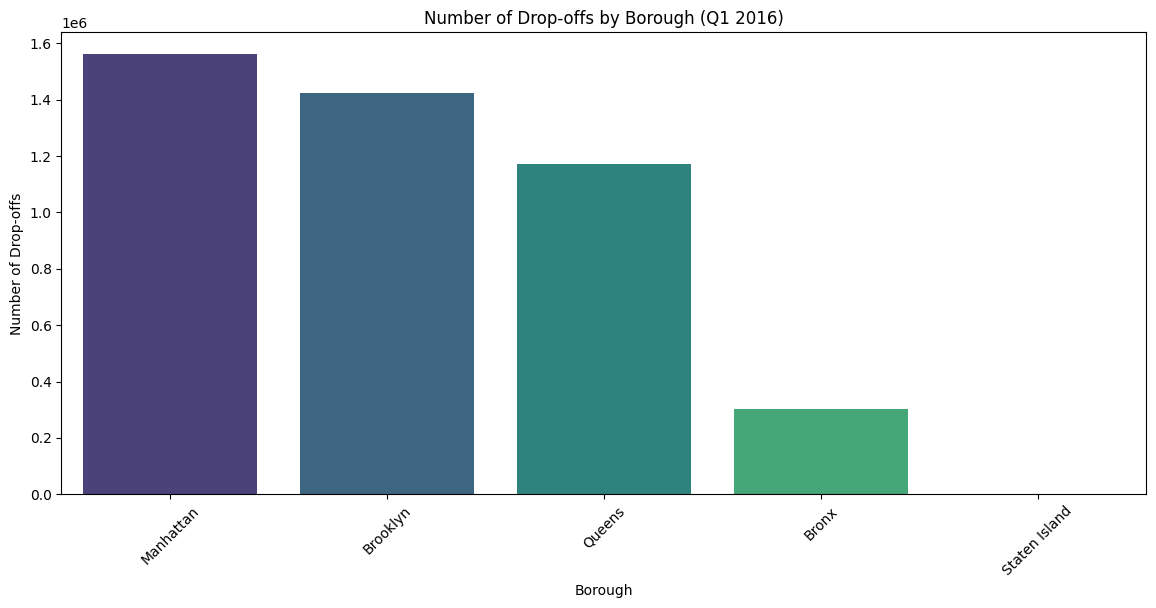

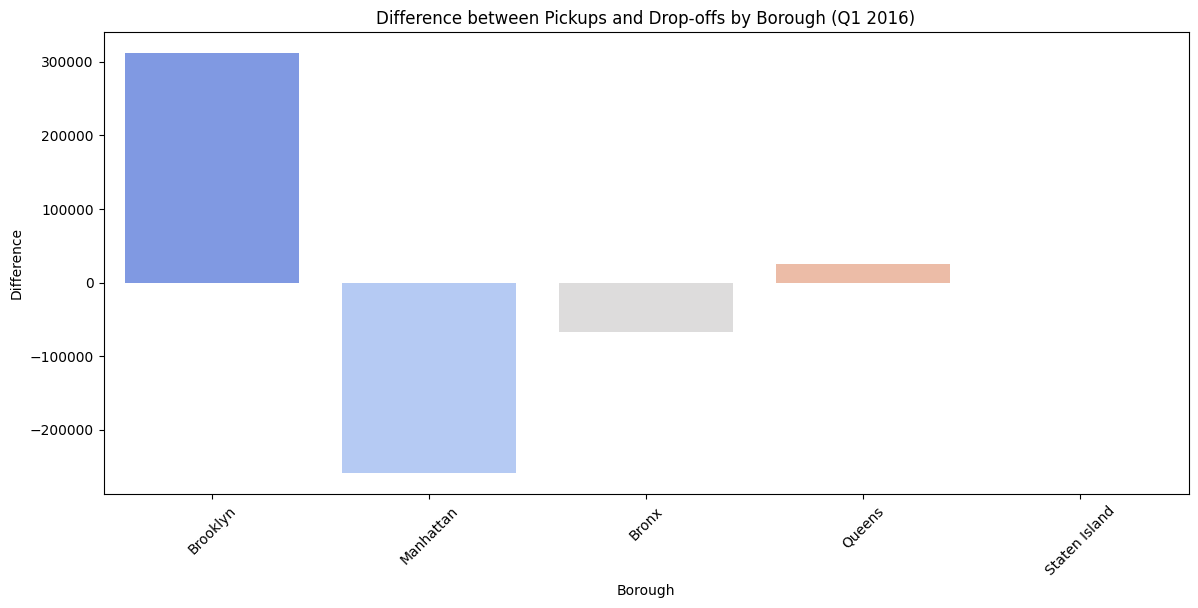

Ride Patterns (Q1 2016):
               Pickups  Drop-offs  Difference  Abs Difference
Brooklyn       1734742    1423098      311644          311644
Manhattan      1301515    1560626     -259111          259111
Bronx           235711     303029      -67318           67318
Queens         1195837    1170248       25589           25589
Staten Island      834       1484        -650             650


In [8]:
# Import necessary libraries
from azureml.opendatasets import NycTlcGreen
from datetime import datetime
from dateutil import parser
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import logging

# Set the logging level to ERROR to suppress verbose logging
logging.getLogger('azureml.opendatasets').setLevel(logging.ERROR)

# Set the date range for Q1 2016
start_date = parser.parse('2016-01-01')
end_date = parser.parse('2016-03-31')

# Fetch the dataset
nyc_tlc = NycTlcGreen(start_date=start_date, end_date=end_date)
nyc_tlc_df = nyc_tlc.to_pandas_dataframe()

# Get the column names
columns = nyc_tlc_df.columns

# Calculate total records and null records per column
total_records = len(nyc_tlc_df)
null_records = nyc_tlc_df.isnull().sum()

# Create a DataFrame for columns info
columns_info = pd.DataFrame({
    'Column Name': columns,
    'Total Records': [total_records] * len(columns),
    'Null Records': null_records
})

# Print the columns in a pretty format
print("Columns in the dataset with total and null records:")
print(tabulate(columns_info, headers="keys", tablefmt="pretty"))

# Load the GeoJSON file for NYC boroughs and neighborhoods
boroughs_geojson_url = "https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson"
boroughs = gpd.read_file(boroughs_geojson_url)

# Ensure necessary columns are present
required_columns = ['pickupLatitude', 'pickupLongitude', 'dropoffLatitude', 'dropoffLongitude']
if not all(col in nyc_tlc_df.columns for col in required_columns):
    print("Required columns are missing. Available columns are:")
    print(nyc_tlc_df.columns)
else:
    # Filter out rows with invalid coordinates
    nyc_tlc_df = nyc_tlc_df[(nyc_tlc_df['pickupLatitude'].between(40, 42)) & 
                            (nyc_tlc_df['pickupLongitude'].between(-75, -72)) &
                            (nyc_tlc_df['dropoffLatitude'].between(40, 42)) &
                            (nyc_tlc_df['dropoffLongitude'].between(-75, -72))]

    # Create GeoDataFrames for pickup and dropoff locations
    pickup_gdf = gpd.GeoDataFrame(nyc_tlc_df, geometry=gpd.points_from_xy(nyc_tlc_df.pickupLongitude, nyc_tlc_df.pickupLatitude), crs="EPSG:4326")
    dropoff_gdf = gpd.GeoDataFrame(nyc_tlc_df, geometry=gpd.points_from_xy(nyc_tlc_df.dropoffLongitude, nyc_tlc_df.dropoffLatitude), crs="EPSG:4326")

    # Spatial join to find the boroughs for pickup and dropoff locations
    pickup_gdf = gpd.sjoin(pickup_gdf, boroughs[['BoroName', 'geometry']], how='left', predicate='within')
    dropoff_gdf = gpd.sjoin(dropoff_gdf, boroughs[['BoroName', 'geometry']], how='left', predicate='within')

    # Analyze ride patterns across different boroughs
    pickup_counts = pickup_gdf['BoroName'].value_counts()
    dropoff_counts = dropoff_gdf['BoroName'].value_counts()

    # Plot the ride patterns for pickups
    plt.figure(figsize=(14, 6))
    sns.barplot(x=pickup_counts.index, y=pickup_counts.values, hue=pickup_counts.index, palette='viridis', legend=False)
    plt.title('Number of Pickups by Borough (Q1 2016)')
    plt.xlabel('Borough')
    plt.ylabel('Number of Pickups')
    plt.xticks(rotation=45)
    plt.legend([],[], frameon=False)
    plt.show()

    # Plot the ride patterns for dropoffs
    plt.figure(figsize=(14, 6))
    sns.barplot(x=dropoff_counts.index, y=dropoff_counts.values, hue=dropoff_counts.index, palette='viridis', legend=False)
    plt.title('Number of Drop-offs by Borough (Q1 2016)')
    plt.xlabel('Borough')
    plt.ylabel('Number of Drop-offs')
    plt.xticks(rotation=45)
    plt.legend([],[], frameon=False)
    plt.show()

    # Identify trends and anomalies by comparing pickups and drop-offs
    ride_patterns = pd.DataFrame({
        'Pickups': pickup_counts,
        'Drop-offs': dropoff_counts
    }).fillna(0)

    ride_patterns['Difference'] = ride_patterns['Pickups'] - ride_patterns['Drop-offs']
    ride_patterns['Abs Difference'] = ride_patterns['Difference'].abs()
    ride_patterns = ride_patterns.sort_values(by='Abs Difference', ascending=False)

    # Plot the differences between pickups and drop-offs
    plt.figure(figsize=(14, 6))
    sns.barplot(x=ride_patterns.index, y=ride_patterns['Difference'], hue=ride_patterns.index, palette='coolwarm', legend=False)
    plt.title('Difference between Pickups and Drop-offs by Borough (Q1 2016)')
    plt.xlabel('Borough')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    plt.legend([],[], frameon=False)
    plt.show()

    # Display ride patterns DataFrame
    print("Ride Patterns (Q1 2016):")
    print(ride_patterns)



{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmp6wot56b0/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=1/part-00119-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2689-1.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmp6wot56b0/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=2/part-00060-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2630-2.c000.snappy.parquet
[Info] read from /var/folders/m1/v2p5dlc135x8ctp72qfss6200000gn/T/tmp6wot56b0/https%3A/%2Fazureopendatastorage.azurefd.net/nyctlc/green/puYear=2016/puMonth=3/part-00196-tid-4753095944193949832-fee7e113-666d-4114-9fcb-bcd3046479f3-2766-1.c000.snappy.parquet
Columns in the dataset with total and null records:
+----------------------+-----------

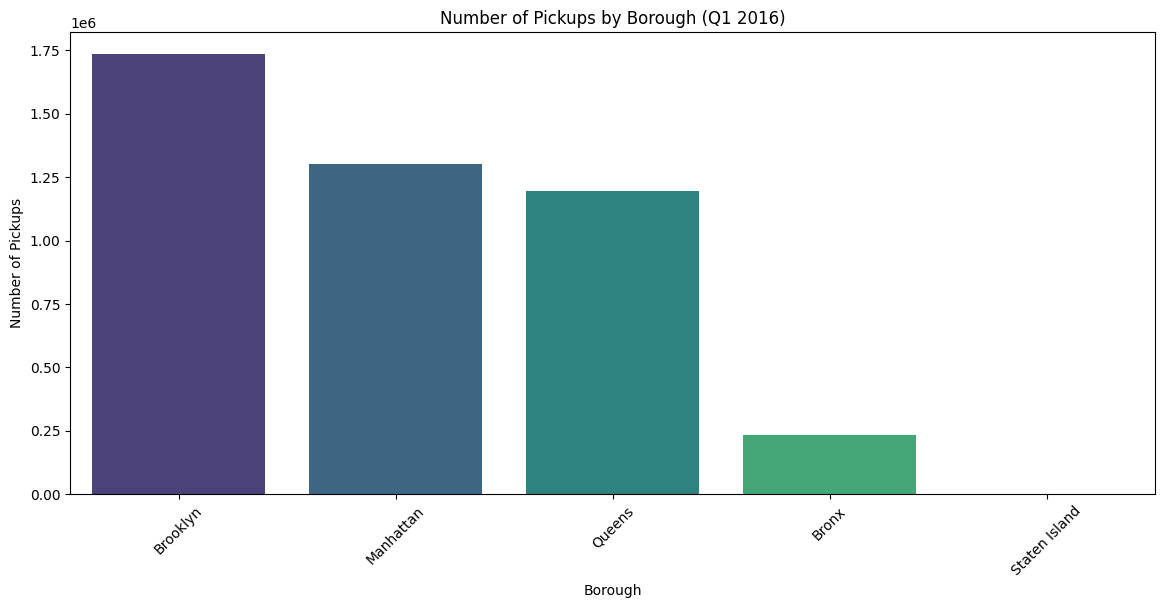

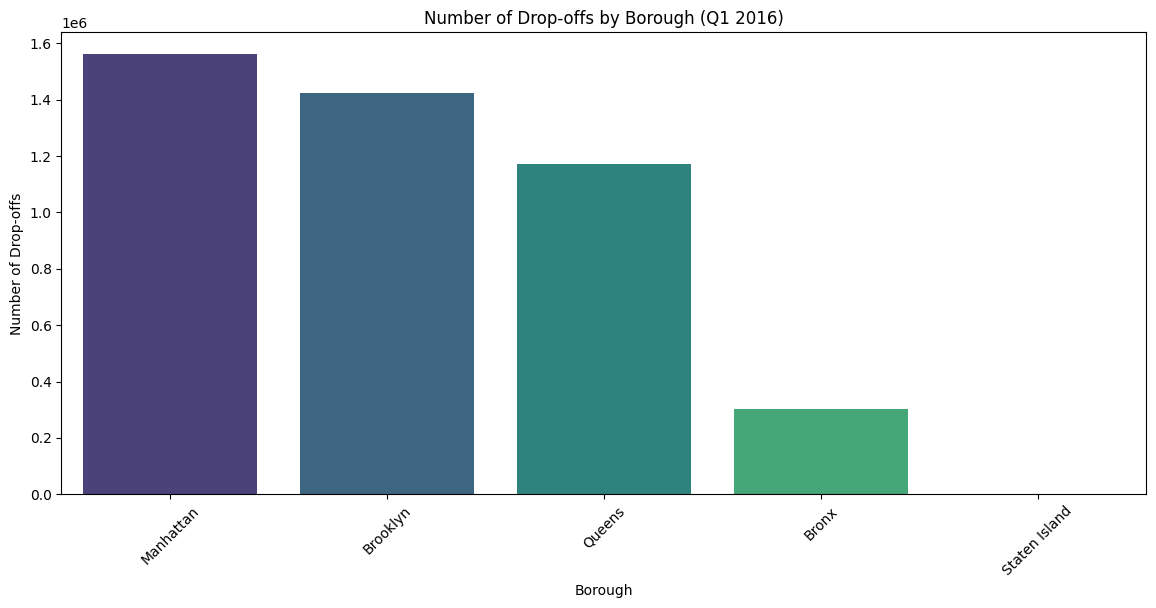

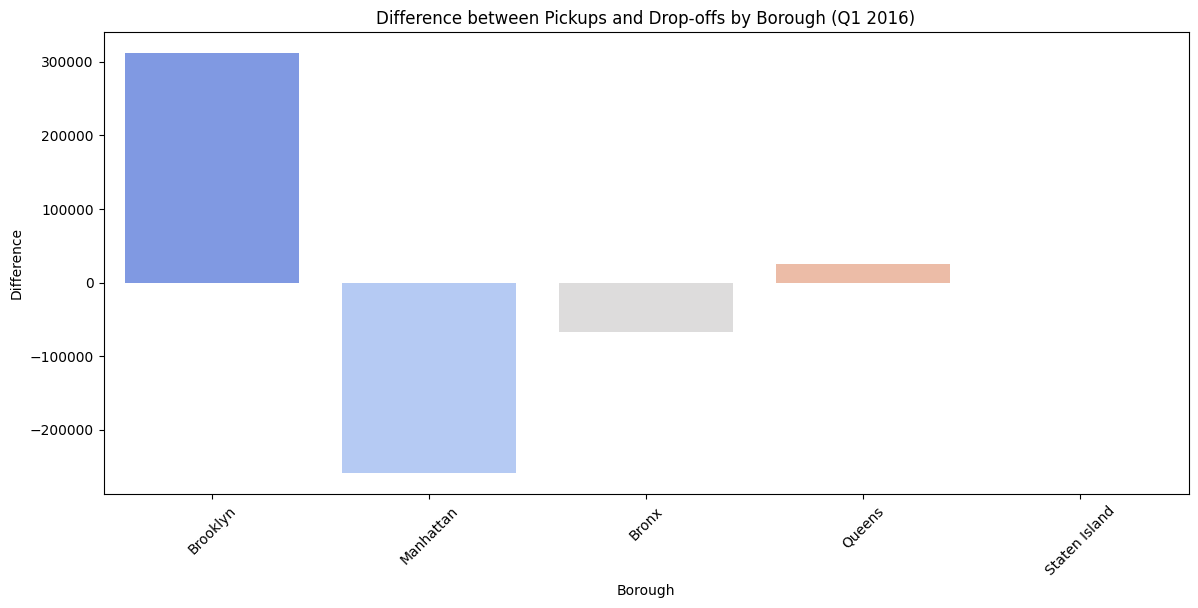

Ride Patterns (Q1 2016):
               Pickups  Drop-offs  Difference  Abs Difference
Brooklyn       1734742    1423098      311644          311644
Manhattan      1301515    1560626     -259111          259111
Bronx           235711     303029      -67318           67318
Queens         1195837    1170248       25589           25589
Staten Island      834       1484        -650             650


In [9]:
# Import necessary libraries
from azureml.opendatasets import NycTlcGreen
from datetime import datetime
from dateutil import parser
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import logging

# Set the logging level to ERROR to suppress verbose logging
logging.getLogger('azureml.opendatasets').setLevel(logging.ERROR)

# Set the date range for Q1 2016
start_date = parser.parse('2016-01-01')
end_date = parser.parse('2016-03-31')

# Fetch the dataset
nyc_tlc = NycTlcGreen(start_date=start_date, end_date=end_date)
nyc_tlc_df = nyc_tlc.to_pandas_dataframe()

# Get the column names
columns = nyc_tlc_df.columns

# Calculate total records and null records per column
total_records = len(nyc_tlc_df)
null_records = nyc_tlc_df.isnull().sum()

# Create a DataFrame for columns info
columns_info = pd.DataFrame({
    'Column Name': columns,
    'Total Records': [total_records] * len(columns),
    'Null Records': null_records
})

# Print the columns in a pretty format
print("Columns in the dataset with total and null records:")
print(tabulate(columns_info, headers="keys", tablefmt="pretty"))

# Save columns info to a CSV file
columns_info.to_csv("columns_info.csv", index=False)

# Load the GeoJSON file for NYC boroughs and neighborhoods
boroughs_geojson_url = "https://raw.githubusercontent.com/dwillis/nyc-maps/master/boroughs.geojson"
boroughs = gpd.read_file(boroughs_geojson_url)

# Ensure necessary columns are present
required_columns = ['pickupLatitude', 'pickupLongitude', 'dropoffLatitude', 'dropoffLongitude']
if not all(col in nyc_tlc_df.columns for col in required_columns):
    print("Required columns are missing. Available columns are:")
    print(nyc_tlc_df.columns)
else:
    # Filter out rows with invalid coordinates
    nyc_tlc_df = nyc_tlc_df[(nyc_tlc_df['pickupLatitude'].between(40, 42)) & 
                            (nyc_tlc_df['pickupLongitude'].between(-75, -72)) &
                            (nyc_tlc_df['dropoffLatitude'].between(40, 42)) &
                            (nyc_tlc_df['dropoffLongitude'].between(-75, -72))]

    # Create GeoDataFrames for pickup and dropoff locations
    pickup_gdf = gpd.GeoDataFrame(nyc_tlc_df, geometry=gpd.points_from_xy(nyc_tlc_df.pickupLongitude, nyc_tlc_df.pickupLatitude), crs="EPSG:4326")
    dropoff_gdf = gpd.GeoDataFrame(nyc_tlc_df, geometry=gpd.points_from_xy(nyc_tlc_df.dropoffLongitude, nyc_tlc_df.dropoffLatitude), crs="EPSG:4326")

    # Spatial join to find the boroughs for pickup and dropoff locations
    pickup_gdf = gpd.sjoin(pickup_gdf, boroughs[['BoroName', 'geometry']], how='left', predicate='within')
    dropoff_gdf = gpd.sjoin(dropoff_gdf, boroughs[['BoroName', 'geometry']], how='left', predicate='within')

    # Analyze ride patterns across different boroughs
    pickup_counts = pickup_gdf['BoroName'].value_counts()
    dropoff_counts = dropoff_gdf['BoroName'].value_counts()

    # Save pickup and dropoff counts to CSV files
    pickup_counts.to_csv("pickup_counts.csv", header=['Count'])
    dropoff_counts.to_csv("dropoff_counts.csv", header=['Count'])

    # Plot the ride patterns for pickups
    plt.figure(figsize=(14, 6))
    sns.barplot(x=pickup_counts.index, y=pickup_counts.values, hue=pickup_counts.index, palette='viridis', legend=False)
    plt.title('Number of Pickups by Borough (Q1 2016)')
    plt.xlabel('Borough')
    plt.ylabel('Number of Pickups')
    plt.xticks(rotation=45)
    plt.legend([], [], frameon=False)
    plt.savefig("pickup_counts.png")
    plt.show()

    # Plot the ride patterns for dropoffs
    plt.figure(figsize=(14, 6))
    sns.barplot(x=dropoff_counts.index, y=dropoff_counts.values, hue=dropoff_counts.index, palette='viridis', legend=False)
    plt.title('Number of Drop-offs by Borough (Q1 2016)')
    plt.xlabel('Borough')
    plt.ylabel('Number of Drop-offs')
    plt.xticks(rotation=45)
    plt.legend([], [], frameon=False)
    plt.savefig("dropoff_counts.png")
    plt.show()

    # Identify trends and anomalies by comparing pickups and drop-offs
    ride_patterns = pd.DataFrame({
        'Pickups': pickup_counts,
        'Drop-offs': dropoff_counts
    }).fillna(0)

    ride_patterns['Difference'] = ride_patterns['Pickups'] - ride_patterns['Drop-offs']
    ride_patterns['Abs Difference'] = ride_patterns['Difference'].abs()
    ride_patterns = ride_patterns.sort_values(by='Abs Difference', ascending=False)

    # Save ride patterns to a CSV file
    ride_patterns.to_csv("ride_patterns.csv")

    # Plot the differences between pickups and drop-offs
    plt.figure(figsize=(14, 6))
    sns.barplot(x=ride_patterns.index, y=ride_patterns['Difference'], hue=ride_patterns.index, palette='coolwarm', legend=False)
    plt.title('Difference between Pickups and Drop-offs by Borough (Q1 2016)')
    plt.xlabel('Borough')
    plt.ylabel('Difference')
    plt.xticks(rotation=45)
    plt.legend([], [], frameon=False)
    plt.savefig("difference_between_pickups_and_dropoffs.png")
    plt.show()

    # Display ride patterns DataFrame
    print("Ride Patterns (Q1 2016):")
    print(ride_patterns)
